## Grandient Boosting Modeling for Reading ##

The models are:
- CatBoost
- XGBoost
- LightGBM
- HistGradientBoosting

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

# import warnings 
# warnings.filterwarnings('ignore')

# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score

### Prepare data ###

Loading the data cleaned from [Task2_EDA.ipynb](../EDA/Task2_EDA.ipynb)

In [3]:
df = pd.read_csv('../EDA/DATA_Texas_District_v2.csv', sep=',', header=0)
print(df.shape)

(955, 90)


Loading the Feature Selection result report from [Task3_Feature_Selection_Reading.ipynb](../EDA/Task3_Feature_Selection_Reading.ipynb)

In [4]:
report = pd.read_csv('../EDA/Task3_Feature_Selection_Reading_Report.csv', sep=',', header=0)
report = report.sort_values(by=['MCC', 'F1'], ascending=False, ignore_index=True)
print(report.shape)

(85, 10)


**Get dummies for categorical feature `Locale`**

In [5]:
df = pd.get_dummies(df, columns=['Locale'], prefix='Locale')
print(df.shape)

(955, 101)


**Split data**

In [6]:
labels = ['Label_Math', 'Label_Reading', 'Label_All']
cols_drop = ['% Tested Math G3 Diff',
            '% Tested Math G4 Diff',
            '% Tested Math G5 Diff',
            '% Tested Math G6 Diff',
            '% Tested Math G7 Diff',
            '% Tested Math G8 Diff',
            'District #', 'County #']


df['Label'] = df['Label_Reading'].apply(lambda x: 0 if x == -1
                                             else 1 if x == 0
                                             else 2)

y = df['Label'].values
X = df.drop(columns=labels + cols_drop + ['Label']).copy()
columns = df.drop(columns=labels + cols_drop + ['Label']).columns.to_list()
categorical_cols = [c for c in columns if 'Locale' in c]
categorical_cols_idx = [columns.index(c) for c in columns if 'Locale' in c]
numerical_cols = [c for c in columns if c not in categorical_cols]

random_state=123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                    random_state=random_state, shuffle=True)
print(X.shape)

(955, 90)


In [7]:
values, counts = np.unique(y_train, return_counts=True)
values_test, counts_test = np.unique(y_test, return_counts=True)
pd.DataFrame({'Label': values.tolist(), 'Train': counts.tolist(), 'Test': counts_test.tolist()})

,Label,Train,Test
0,0,173,43
1,1,409,102
2,2,182,46


**Normalization**

In [8]:
scaler = StandardScaler()

scaler.fit(X_train[numerical_cols])
X_train[numerical_cols] = scaler.transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

### Experiment with the Feature Sets selected from [Task3_Feature_Selection_Reading.ipynb](../EDA/Task3_Feature_Selection_Reading.ipynb) ###

In [9]:
print('Feature Set 1 (Original Set)')
print('\tn features:', len(columns))

feature_set = report[(report['model'] == 'Ridge') & (report['type'] == 'by methods')].sort_values(by=['n Selected'], ignore_index=True)
n = feature_set.shape[0]

for i in range(n):
    print('Feature Set', str(i+2))
    print('\tn features: {:0.0f}'.format(feature_set.loc[i, 'n Selected']))
    if feature_set.loc[i, 'type'] == 'by counts': 
        print('\tSelected by {:0.0f} methods'.format(feature_set.loc[i, 'Counts']))

Feature Set 1 (Original Set)
	n features: 90
Feature Set 2
	n features: 5
Feature Set 3
	n features: 20
Feature Set 4
	n features: 26
Feature Set 5
	n features: 36
Feature Set 6
	n features: 45
Feature Set 7
	n features: 45
Feature Set 8
	n features: 45
Feature Set 9
	n features: 51
Feature Set 10
	n features: 82


### Modeling ###

In [10]:
n_iter_denom = 4
rounds = 20

In [11]:
def model_report(estimator, param_grid, fit_params, name, categorical=False):
    result = pd.DataFrame()
    avg = 'weighted'
    cv=5
    
    n_iter = 1
    for v in param_grid.values(): n_iter*=len(v)
    n_iter /= n_iter_denom
    print('{} n_iter: {:0.0f}'.format(name, n_iter))
    if name == 'CatBoost': n_iter=100
        
    for i in range(n+1):
        if i == n: 
            features = columns
            method = 'No Reduction'
        else: 
            features = list(feature_set.loc[i, 'features'].strip("[]''").split("', '"))
            method = feature_set.loc[i, 'Method']
         
        X_train2 = X_train.loc[:, features]
        X_test2 = X_test.loc[:, features]        
                
        if categorical:
            categorical_cols2=[features.index(f) for f in features if f in categorical_cols]
            if len(categorical_cols2) > 0:
                if (name == 'LightGBM'): fit_params['categorical_feature']=categorical_cols2
                if (name == 'CatBoost'): fit_params['cat_features']=categorical_cols2
                if (name == 'HistGB'): estimator.set_params(**{'categorical_features': categorical_cols2})
            else: 
                if (name == 'LightGBM'): fit_params['categorical_feature']=None
                if (name == 'CatBoost'): fit_params['cat_features']=None
                if (name == 'HistGB'): estimator.set_params(**{'categorical_features': None})
     
        grid = RandomizedSearchCV(estimator, param_distributions=param_grid, cv=cv, n_jobs=-1, 
                              random_state=random_state, n_iter=n_iter)

        start_cpu = time.process_time()
        start_wall = time.time()
        
        if name == 'CatBoost':
            fit_params['eval_set'] =  [(X_test2, y_test)]
            grid.fit(X_train2, y_train, **fit_params)            
        elif name == 'HistGB': 
            grid.fit(X_train2, y_train)
        else:
            fit_params['eval_set'] =  [(X_test2.values, y_test)]
            grid.fit(X_train2.values, y_train, **fit_params)
            
        cpu_time = time.process_time() - start_cpu
        wall_time = time.time() - start_wall
        y_pred = grid.best_estimator_.predict(X_test2)
        
        temp = {'Model': name,
                'n Selected': len(features),
                'Method': method,
                'best_params': grid.best_params_,
                'Best Accuracy': grid.best_score_, 
                'Train Accuracy': grid.best_estimator_.score(X_train2, y_train),
                'Test Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred, average=avg),
                'Recall': recall_score(y_test, y_pred, average=avg),
                'MCC': matthews_corrcoef(y_test, y_pred), 
                'F1': f1_score(y_test, y_pred, average=avg),
#                 'ROC': roc_auc_score(y_test, grid.best_estimator_.predict_proba(X_test2), multi_class='ovr', average=avg),
                'conf_mat': confusion_matrix(y_test, y_pred), 
                'Prediction': y_pred,
                'predict_proba': grid.best_estimator_.predict_proba(X_test2),
                'Features': features,
                'estimator': grid.best_estimator_,
                'classification_report': classification_report(y_test, y_pred),
                'Train Time CPU': cpu_time,
                'Train Time Wall': wall_time,
                'n_iter': n_iter}
        result = pd.concat([result, pd.DataFrame([temp])], ignore_index=True)
    return result

In [12]:
results = pd.DataFrame()

**CatBoost**

In [13]:
%%time
from catboost import CatBoostClassifier

params = {'iterations': [50, 100, 200],
'depth': [3, 6, 9],
'min_data_in_leaf': [1, 5, 10],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'l2_leaf_reg': [0, 0.01, 0.1, 1, 10],
'random_strength': [0, 5, 10, 15]}

fit_params = {'early_stopping_rounds': rounds}

estimator = CatBoostClassifier(random_seed=random_state, verbose=False, one_hot_max_size=2,
                               loss_function='MultiClass', eval_metric="MultiClass")
result_report=model_report(estimator, params, fit_params, 'CatBoost', True)
results=pd.concat([results, result_report], ignore_index=True)

CatBoost n_iter: 540


C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML39\lib\site-pa

CPU times: total: 1min 30s
Wall time: 1h 56min 24s


**XGBoost**

In [14]:
%%time
import xgboost

params = {'n_estimators': [50, 100, 200],
'max_depth': [1, 6, 0],
'min_child_weight': [0, 0.001, 0.1, 1],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'alpha': [0,  0.1, 10],
'lambda': [0,  0.1, 10],
'gamma': [0,  0.1, 10]}

fit_params = {'early_stopping_rounds': rounds,
              'eval_metric': 'mlogloss'}

estimator = xgboost.XGBClassifier(seed=random_state, use_label_encoder=False, verbosity=0, slient=1,
                                  num_class=3, objective='multi:softmax')
result_report=model_report(estimator, params, fit_params, 'XGBoost', False)
results=pd.concat([results, result_report], ignore_index=True)

XGBoost n_iter: 972


C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[0]	validation_0-mlogloss:1.05151
[1]	validation_0-mlogloss:1.02382
[2]	validation_0-mlogloss:0.99875
[3]	validation_0-mlogloss:0.97896
[4]	validation_0-mlogloss:0.96536
[5]	validation_0-mlogloss:0.95336
[6]	validation_0-mlogloss:0.94567
[7]	validation_0-mlogloss:0.93516
[8]	validation_0-mlogloss:0.93077
[9]	validation_0-mlogloss:0.92632
[10]	validation_0-mlogloss:0.92236
[11]	validation_0-mlogloss:0.91896
[12]	validation_0-mlogloss:0.91499
[13]	validation_0-mlogloss:0.91292
[14]	validation_0-mlogloss:0.91024
[15]	validation_0-mlogloss:0.90839
[16]	validation_0-mlogloss:0.90705
[17]	validation_0-mlogloss:0.90823
[18]	validation_0-mlogloss:0.90780
[19]	validation_0-mlogloss:0.90746
[20]	validation_0-mlogloss:0.90798
[21]	validation_0-mlogloss:0.90732
[22]	validation_0-mlogloss:0.90773
[23]	validation_0-mlogloss:0.90878
[24]	validation_0-mlogloss:0.90753
[25]	validation_0-mlogloss:0.90819
[26]	validation_0-mlogloss:0.90831
[27]	validation_0-mlogloss:0.90841
[28]	validation_0-mlogloss:0.9

C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML39\lib\site-pa

[0]	validation_0-mlogloss:1.05290
[1]	validation_0-mlogloss:1.02707
[2]	validation_0-mlogloss:1.00719
[3]	validation_0-mlogloss:0.99422
[4]	validation_0-mlogloss:0.98506
[5]	validation_0-mlogloss:0.98087
[6]	validation_0-mlogloss:0.97580
[7]	validation_0-mlogloss:0.97254
[8]	validation_0-mlogloss:0.97254
[9]	validation_0-mlogloss:0.97085
[10]	validation_0-mlogloss:0.96805
[11]	validation_0-mlogloss:0.96934
[12]	validation_0-mlogloss:0.96952
[13]	validation_0-mlogloss:0.96738
[14]	validation_0-mlogloss:0.96959
[15]	validation_0-mlogloss:0.96679
[16]	validation_0-mlogloss:0.96798
[17]	validation_0-mlogloss:0.96673
[18]	validation_0-mlogloss:0.96976
[19]	validation_0-mlogloss:0.97234
[20]	validation_0-mlogloss:0.97248
[21]	validation_0-mlogloss:0.97248
[22]	validation_0-mlogloss:0.97248
[23]	validation_0-mlogloss:0.97248
[24]	validation_0-mlogloss:0.97248
[25]	validation_0-mlogloss:0.97248
[26]	validation_0-mlogloss:0.97248
[27]	validation_0-mlogloss:0.97248
[28]	validation_0-mlogloss:0.9

[85]	validation_0-mlogloss:0.96897
[86]	validation_0-mlogloss:0.96821
[87]	validation_0-mlogloss:0.96743
[88]	validation_0-mlogloss:0.96675
[89]	validation_0-mlogloss:0.96586
[90]	validation_0-mlogloss:0.96518
[91]	validation_0-mlogloss:0.96455
[92]	validation_0-mlogloss:0.96371
[93]	validation_0-mlogloss:0.96302
[94]	validation_0-mlogloss:0.96246
[95]	validation_0-mlogloss:0.96150
[96]	validation_0-mlogloss:0.96081
[97]	validation_0-mlogloss:0.96022
[98]	validation_0-mlogloss:0.95943
[99]	validation_0-mlogloss:0.95883
[0]	validation_0-mlogloss:1.03039
[1]	validation_0-mlogloss:0.99644
[2]	validation_0-mlogloss:0.96852
[3]	validation_0-mlogloss:0.94821
[4]	validation_0-mlogloss:0.92694
[5]	validation_0-mlogloss:0.91893
[6]	validation_0-mlogloss:0.90972
[7]	validation_0-mlogloss:0.89955
[8]	validation_0-mlogloss:0.89281
[9]	validation_0-mlogloss:0.88934
[10]	validation_0-mlogloss:0.88762
[11]	validation_0-mlogloss:0.88479
[12]	validation_0-mlogloss:0.88236
[13]	validation_0-mlogloss:0.8

**LightGBM**

In [15]:
%%time
import lightgbm as lgb

params = {'n_estimators': [50, 100, 200],
'max_depth': [1, 6, -1],
'min_sum_hessian_in_leaf': [0, 0.001, 0.1, 1],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'reg_alpha': [0,  0.1, 10],
'reg_lambda': [0,  0.1, 10],
'min_split_gain': [0,  0.1, 10]}

fit_params = {'eval_metric': 'multi_logloss',
              'early_stopping_rounds': rounds}

estimator = lgb.LGBMClassifier(seed=random_state, verbosity=-1, silent=True, force_col_wise=True,
                               objective="multiclass", num_class=3, is_unbalance=True)
result_report=model_report(estimator, params, fit_params, 'LightGBM', True)
results=pd.concat([results, result_report], ignore_index=True)

LightGBM n_iter: 972
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[1]	valid_0's multi_logloss: 0.979734
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.956858
[3]	valid_0's multi_logloss: 0.941611
[4]	valid_0's multi_logloss: 0.932521
[5]	valid_0's multi_logloss: 0.923652
[6]	valid_0's multi_logloss: 0.913736
[7]	valid_0's multi_logloss: 0.908723
[8]	valid_0's multi_logloss: 0.908008
[9]	valid_0's multi_logloss: 0.906893
[10]	valid_0's multi_logloss: 0.90345
[11]	valid_0's multi_logloss: 0.902938
[12]	valid_0's multi_logloss: 0.904379
[13]	valid_0's multi_logloss: 0.903194
[14]	valid_0's multi_logloss: 0.903293
[15]	valid_0's multi_logloss: 0.903916
[16]	valid_0's multi_logloss: 0.903305
[17]	valid_0's multi_logloss: 0.904463
[18]	valid_0's multi_logloss: 0.904511
[19]	valid_0's multi_logloss: 0.905281
[20]	valid_0's multi_logloss: 0.9074
[21]	v

C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML39\lib\site-pa

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.1
[1]	valid_0's multi_logloss: 0.999862
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.991479
[3]	valid_0's multi_logloss: 0.986282
[4]	valid_0's multi_logloss: 0.979284
[5]	valid_0's multi_logloss: 0.978993
[6]	valid_0's multi_logloss: 0.97887
[7]	valid_0's multi_logloss: 0.975126
[8]	valid_0's multi_logloss: 0.97532
[9]	valid_0's multi_logloss: 0.974879
[10]	valid_0's multi_logloss: 0.975553
[11]	valid_0's multi_logloss: 0.977387
[12]	valid_0's multi_logloss: 0.982114
[13]	valid_0's multi_logloss: 0.988677
[14]	valid_0's multi_logloss: 0.994452
[15]	valid_0's multi_logloss: 0.995806
[16]	valid_0's multi_logloss: 0.998793
[17]	valid_0's multi_logloss: 1.00442
[18]	valid_0's multi_logloss: 1.00533
[19]	valid_0's multi_logloss: 1.01081
[20]	valid_0's multi_logloss: 1.01865
[21]	valid_0's multi_logloss: 1.02

C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [19, 20, 21, 22, 32, 33]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[1]	valid_0's multi_logloss: 0.973623
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.953272
[3]	valid_0's multi_logloss: 0.946245
[4]	valid_0's multi_logloss: 0.935928
[5]	valid_0's multi_logloss: 0.930145
[6]	valid_0's multi_logloss: 0.924122
[7]	valid_0's multi_logloss: 0.926927
[8]	valid_0's multi_logloss: 0.94129
[9]	valid_0's multi_logloss: 0.939963
[10]	valid_0's multi_logloss: 0.945826
[11]	valid_0's multi_logloss: 0.947927
[12]	valid_0's multi_logloss: 0.95091
[13]	valid_0's multi_logloss: 0.951788
[14]	valid_0's multi_logloss: 0.953872
[15]	valid_0's multi_logloss: 0.956878
[16]	valid_0's multi_logloss: 0.954695
[17]	valid_0's multi_logloss: 0.961011
[18]	valid_0's multi_logloss: 0.968255
[19]	valid_0's multi_logloss: 0.981101
[20]	valid_0's multi_logloss: 0.984389
[21]	valid_0's multi_logloss: 0.98

C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [22, 23, 24, 25, 34, 35, 36, 37, 38, 39, 40, 41]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[1]	valid_0's multi_logloss: 0.997387
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.983297
[3]	valid_0's multi_logloss: 0.972663
[4]	valid_0's multi_logloss: 0.964253
[5]	valid_0's multi_logloss: 0.955899
[6]	valid_0's multi_logloss: 0.949001
[7]	valid_0's multi_logloss: 0.943923
[8]	valid_0's multi_logloss: 0.940652
[9]	valid_0's multi_logloss: 0.937288
[10]	valid_0's multi_logloss: 0.933446
[11]	valid_0's multi_logloss: 0.931824
[12]	valid_0's multi_logloss: 0.929148
[13]	valid_0's multi_logloss: 0.926776
[14]	valid_0's multi_logloss: 0.923813
[15]	valid_0's multi_logloss: 0.92129
[16]	valid_0's multi_logloss: 0.919951
[17]	valid_0's multi_logloss: 0.91941
[18]	valid_0's multi_logloss: 0.918034
[19]	valid_0's multi_logloss: 0.917723
[20]	valid_0's multi_logloss: 0.915677
[21]	valid_0's multi_logloss: 0.91

C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [22, 23, 24, 25, 34, 35, 36, 37, 38, 39, 40, 41]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.1
[1]	valid_0's multi_logloss: 0.977359
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.944261
[3]	valid_0's multi_logloss: 0.948908
[4]	valid_0's multi_logloss: 0.953098
[5]	valid_0's multi_logloss: 0.974416
[6]	valid_0's multi_logloss: 0.977263
[7]	valid_0's multi_logloss: 0.979952
[8]	valid_0's multi_logloss: 1.0032
[9]	valid_0's multi_logloss: 0.996832
[10]	valid_0's multi_logloss: 0.99545
[11]	valid_0's multi_logloss: 1.00812
[12]	valid_0's multi_logloss: 1.01445
[13]	valid_0's multi_logloss: 1.03897
[14]	valid_0's multi_logloss: 1.04292
[15]	valid_0's multi_logloss: 1.06144
[16]	valid_0's multi_logloss: 1.06285
[17]	valid_0's multi_logloss: 1.0693
[18]	valid_0's multi_logloss: 1.07897
[19]	valid_0's multi_logloss: 1.08901
[20]	valid_0's multi_logloss: 1.1029
[21]	valid_0's multi_logloss: 1.1159
[22]	v

C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [31, 32, 33, 34, 56, 57, 58, 59, 60]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.1
[1]	valid_0's multi_logloss: 0.993926
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.978418
[3]	valid_0's multi_logloss: 0.967294
[4]	valid_0's multi_logloss: 0.956704
[5]	valid_0's multi_logloss: 0.950073
[6]	valid_0's multi_logloss: 0.941345
[7]	valid_0's multi_logloss: 0.935541
[8]	valid_0's multi_logloss: 0.930708
[9]	valid_0's multi_logloss: 0.924601
[10]	valid_0's multi_logloss: 0.923392
[11]	valid_0's multi_logloss: 0.919843
[12]	valid_0's multi_logloss: 0.916327
[13]	valid_0's multi_logloss: 0.914619
[14]	valid_0's multi_logloss: 0.914202
[15]	valid_0's multi_logloss: 0.912858
[16]	valid_0's multi_logloss: 0.910716
[17]	valid_0's multi_logloss: 0.908504
[18]	valid_0's multi_logloss: 0.908779
[19]	valid_0's multi_logloss: 0.908124
[20]	valid_0's multi_logloss: 0.906694
[21]	valid_0's multi_logloss

C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


**HistGradientBoosting**

In [16]:
%%time
from sklearn.ensemble import HistGradientBoostingClassifier

params = {'max_iter': [50, 100, 200],
'max_depth': [1, 6, None],
'max_leaf_nodes': [10, 31, 50, 64],
'min_samples_leaf': [10, 20, 30],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'l2_regularization': [0, 0.01, 0.1, 1, 10]}

fit_params = {}

estimator=HistGradientBoostingClassifier(random_state=random_state, n_iter_no_change=rounds, early_stopping=True)
result_report=model_report(estimator, params, fit_params, 'HistGB', True)
results=pd.concat([results, result_report], ignore_index=True)

HistGB n_iter: 540
CPU times: total: 2min 20s
Wall time: 43min 47s


In [28]:
results.to_csv('Task4_Modeling_GB_Reading.csv', index=False)

## Result ##

In [18]:
results.sort_values(by=['MCC', 'F1'], ascending=False).head(10)[['Model', 'Method', 'n Selected', 'Test Accuracy', 'MCC', 'F1', 'best_params']]

,Model,Method,n Selected,Test Accuracy,MCC,F1,best_params
8,CatBoost,Permutation Importance - Ridge,82,0.623037,0.337826,0.547543,"{'random_strength': 5, 'min_data_in_leaf': 5, ..."
25,LightGBM,Feature Importance - Random Forest,45,0.617801,0.324317,0.539714,"{'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimat..."
15,XGBoost,Feature Importance - Random Forest,45,0.612565,0.311504,0.558054,"{'n_estimators': 200, 'min_child_weight': 1, '..."
13,XGBoost,RFE - Random Forest,36,0.612565,0.309473,0.543204,"{'n_estimators': 100, 'min_child_weight': 0.1,..."
10,XGBoost,RFE - Ridge,5,0.591623,0.265926,0.502555,"{'n_estimators': 100, 'min_child_weight': 0, '..."
3,CatBoost,RFE - Random Forest,36,0.591623,0.263592,0.515893,"{'random_strength': 0, 'min_data_in_leaf': 5, ..."
2,CatBoost,Permutation Importance - Random Forest,26,0.586387,0.253217,0.529265,"{'random_strength': 15, 'min_data_in_leaf': 1,..."
5,CatBoost,Feature Importance - Random Forest,45,0.581152,0.244667,0.502807,"{'random_strength': 10, 'min_data_in_leaf': 1,..."
29,LightGBM,No Reduction,90,0.575916,0.234274,0.510021,"{'reg_lambda': 0, 'reg_alpha': 10, 'n_estimato..."
6,CatBoost,SFS - KNN,45,0.575916,0.233582,0.509711,"{'random_strength': 15, 'min_data_in_leaf': 5,..."


In [19]:
results.sort_values(by=['MCC', 'F1'], ascending=False).head(10)['Model'].value_counts().to_frame()

,Model
CatBoost,5
XGBoost,3
LightGBM,2


In [20]:
results.sort_values(by=['MCC', 'F1'], ascending=False).head(10)['n Selected'].value_counts().sort_index().to_frame()

,n Selected
5,1
26,1
36,2
45,4
82,1
90,1


**Accuracy, MCC and F1 Score**

In [21]:
results2 = pd.DataFrame()
for col in ['Train Accuracy', 'Test Accuracy', 'MCC', 'F1']:
    temp = results[['Model', 'n Selected'] + [col]].copy()
    temp['Score'] = col
    temp.rename(columns={col: 'Score value'}, inplace=True)
    results2 = pd.concat([results2, temp], ignore_index=True)
results2=results2.astype({'n Selected': 'int32'})

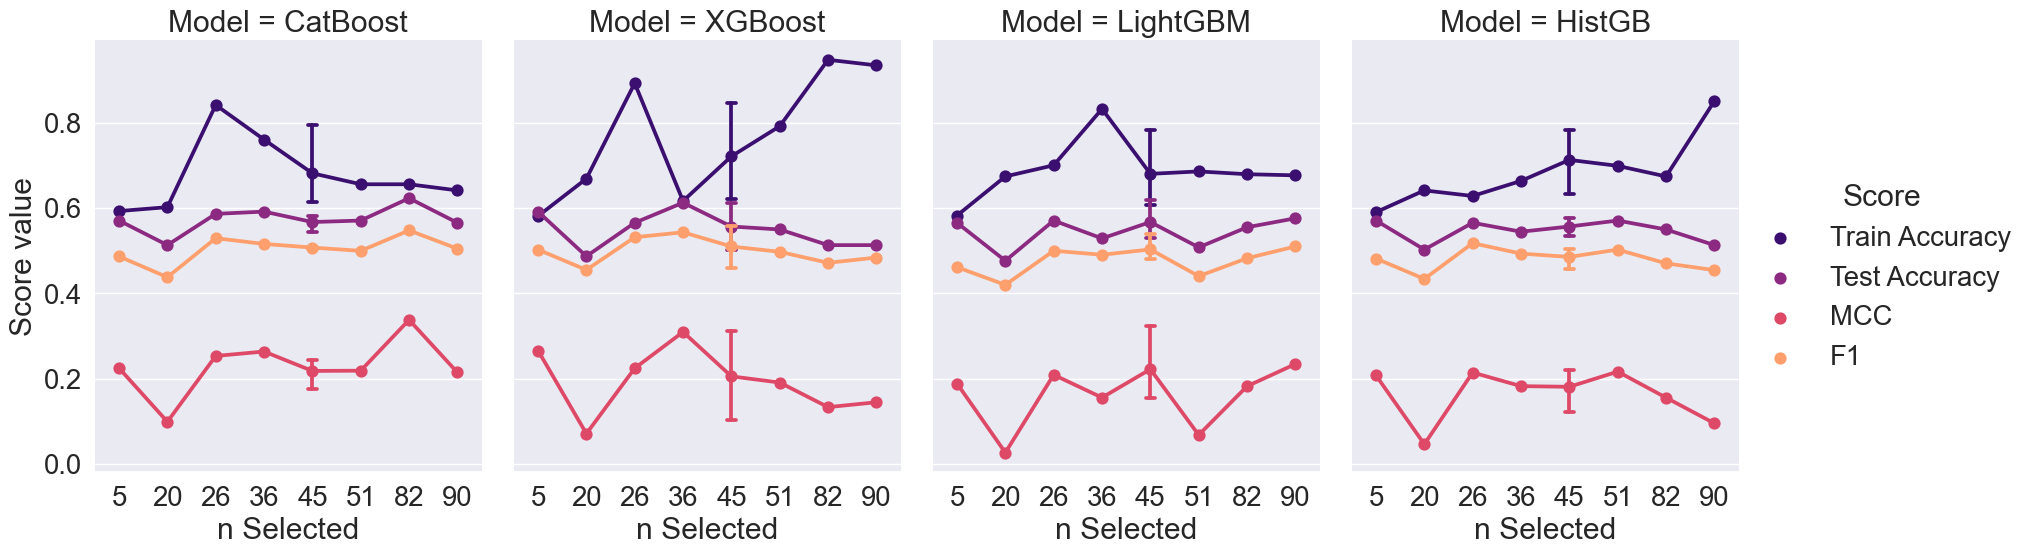

In [22]:
sns.set(rc={'figure.figsize':(20,20)})
sns.set_theme(style='whitegrid')
sns.set(font_scale=1.8)

g = sns.catplot(x="n Selected", y="Score value", hue="Score", col="Model",
                capsize=.2, palette="magma", height=6, aspect=.75,
                kind="point", data=results2)
g.despine(left=True)
plt.show()

In [23]:
models = results['Model'].unique().tolist()
temp=results.sort_values(by=['Model', 'MCC', 'F1'], ascending=False)

best_per_model_idx = []
for i in range(len(temp.index)):
    if i % (n+1) == 0: best_per_model_idx.append(temp.index[i])

**Confusion Matrix**

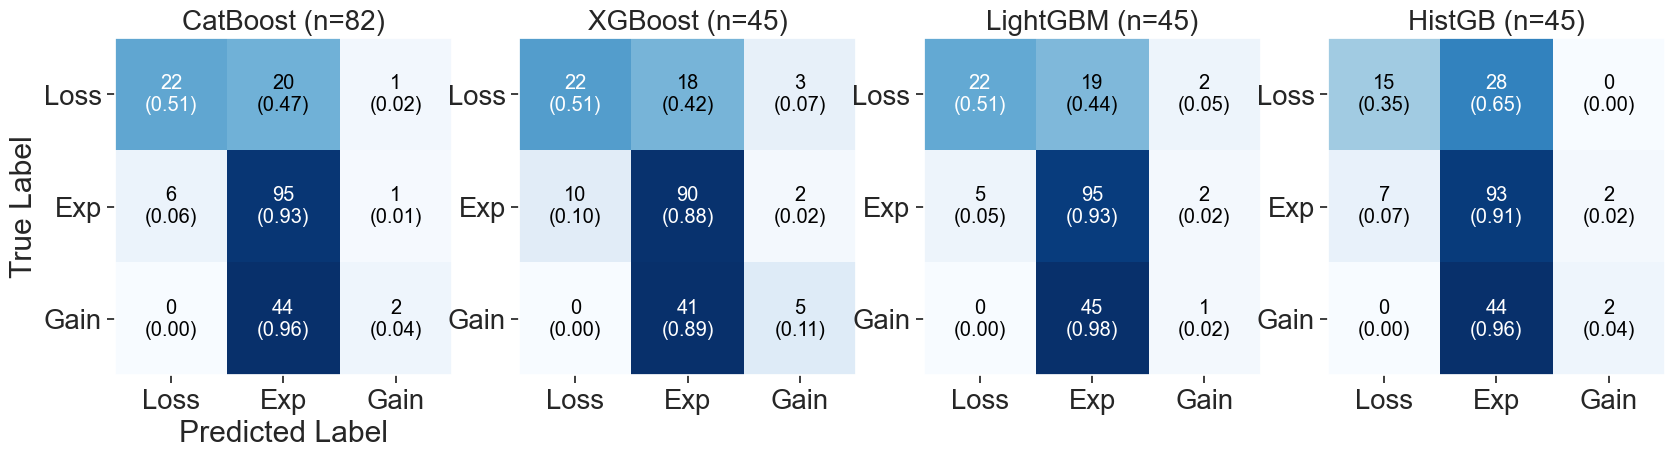

In [24]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.ticker as mticker

def ticks(x, position):
    if position == 1: return 'Loss'
    if position == 2: return 'Exp'
    if position == 3: return 'Gain'
    
fig, axes=plt.subplots(1,len(best_per_model_idx), figsize=(20,10))
sns.set(font_scale=1.2)

for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    plot_confusion_matrix(axis=axes[i], conf_mat=results.loc[idx, 'conf_mat'],
                          show_absolute=True, show_normed=True)
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    axes[i].set_title(title, fontsize=20)
    if (i > 0): axes[i].set(xlabel='', ylabel='')
    else : axes[i].set(xlabel='Predicted Label', ylabel='True Label')
    axes[i].xaxis.set_major_formatter(mticker.FuncFormatter(ticks))
    axes[i].yaxis.set_major_formatter(mticker.FuncFormatter(ticks))
plt.show()

**ROC Curve**

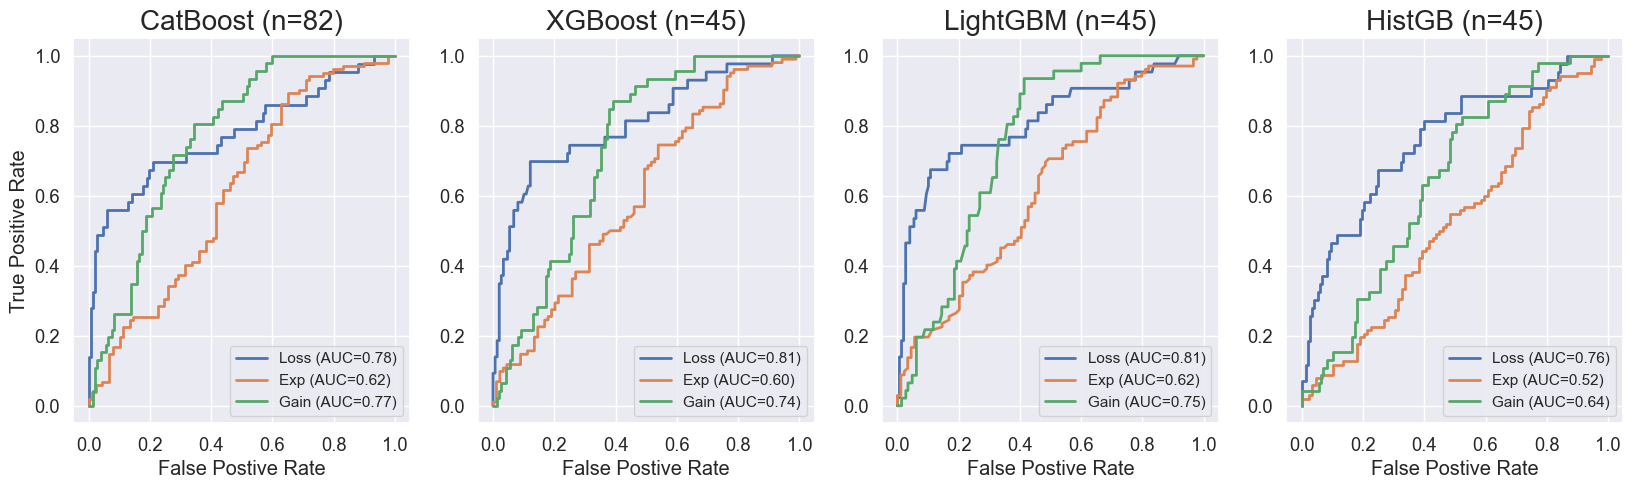

In [25]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

classes=[0, 1, 2]
y_test_bin=label_binarize(y_test, classes=classes)

fig, axes=plt.subplots(1,len(best_per_model_idx), figsize=(20,5))
sns.set(font_scale=1)

for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    fpr, tpr = {}, {}

    for c in classes:
        fpr[c], tpr[c], _ = roc_curve(y_test_bin[:, c], results.loc[idx, 'predict_proba'][:, c])
        axes[i].plot(fpr[c], tpr[c], lw=2, label='{} (AUC={:0.2f})'.format(ticks(c,c+1), auc(fpr[c], tpr[c])))
    
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    axes[i].set_title(title, fontsize=20)
    axes[i].set_xlabel("False Postive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[i].legend(loc="best")

plt.show()

**Precision-Recall Curve**

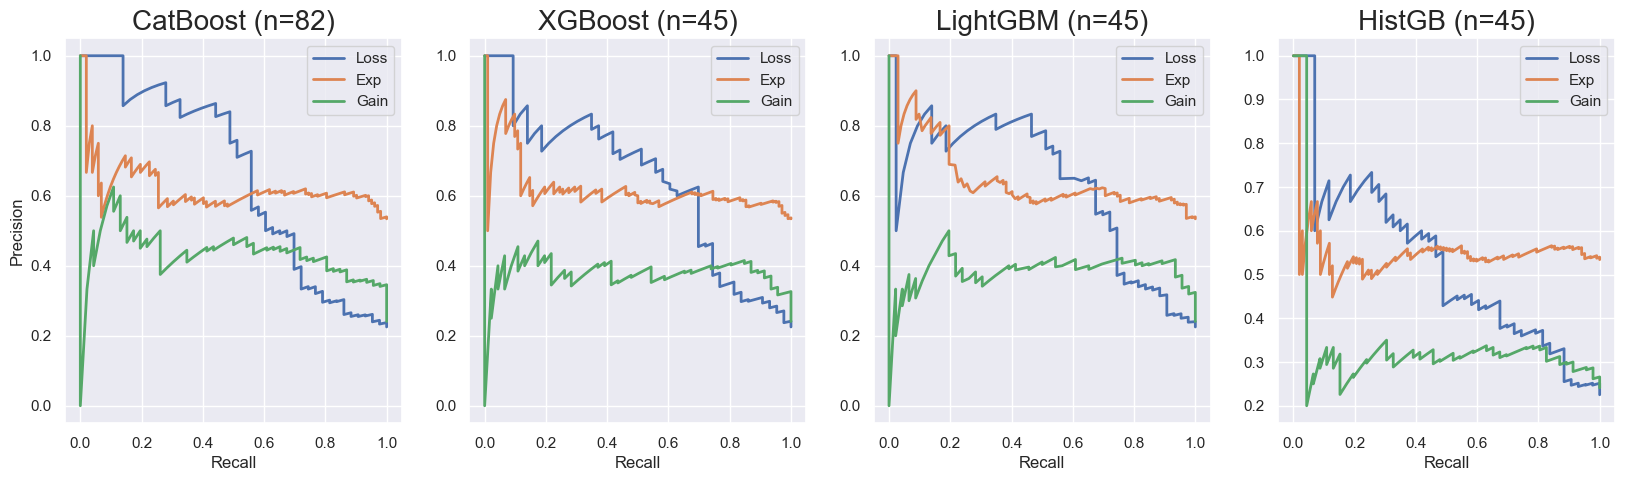

In [26]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve

classes=[0, 1, 2]
y_test_bin=label_binarize(y_test, classes=classes)

fig, axes=plt.subplots(1,len(best_per_model_idx), figsize=(20,5))
sns.set(font_scale=1)

for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    prec, rec = {}, {}

    for c in classes:
        prec[c], rec[c], _ = precision_recall_curve(y_test_bin[:, c], results.loc[idx, 'predict_proba'][:, c])
        axes[i].plot(rec[c], prec[c], lw=2, label='{}'.format(ticks(c,c+1)))
    
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    axes[i].set_title(title, fontsize=20)
    axes[i].set_xlabel("Recall")
    axes[0].set_ylabel("Precision")
    axes[i].legend(loc="best")

plt.show()

In [27]:
for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    print(title, '\n', results.loc[idx, 'classification_report'])

CatBoost (n=82) 
               precision    recall  f1-score   support

           0       0.79      0.51      0.62        43
           1       0.60      0.93      0.73       102
           2       0.50      0.04      0.08        46

    accuracy                           0.62       191
   macro avg       0.63      0.50      0.48       191
weighted avg       0.62      0.62      0.55       191

XGBoost (n=45) 
               precision    recall  f1-score   support

           0       0.69      0.51      0.59        43
           1       0.60      0.88      0.72       102
           2       0.50      0.11      0.18        46

    accuracy                           0.61       191
   macro avg       0.60      0.50      0.49       191
weighted avg       0.60      0.61      0.56       191

LightGBM (n=45) 
               precision    recall  f1-score   support

           0       0.81      0.51      0.63        43
           1       0.60      0.93      0.73       102
           2       0.2